In [1]:
%pip install medmnist

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler
from torchsummary import summary
import torchvision
from  torchvision import transforms
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO
import time
import torch.nn.functional as F


In [3]:
info = INFO['bloodmnist']
task = info['task']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

trainset = DataClass(split='train', transform=transforms.ToTensor(), download=True)
testset = DataClass(split='test', transform=transforms.ToTensor(), download=True)

train_dataloader = data.DataLoader(dataset=trainset, batch_size=128, shuffle=True)
test_dataloader = data.DataLoader(dataset=testset, batch_size=128, shuffle=False)


Using downloaded and verified file: /home/lukrecija/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/lukrecija/.medmnist/bloodmnist.npz


In [4]:
def extract_unique_labels(dataset):
    unique_labels = set()
    for _, label in dataset:
        if isinstance(label, np.ndarray):
            label = int(label[0])
        unique_labels.add(label)
    return sorted(list(unique_labels))

unique_labels_train = extract_unique_labels(trainset)
unique_labels_test = extract_unique_labels(testset)
classes = unique_labels_train
print(classes)


[0, 1, 2, 3, 4, 5, 6, 7]


/tmp/ipykernel_4904/2591191304.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


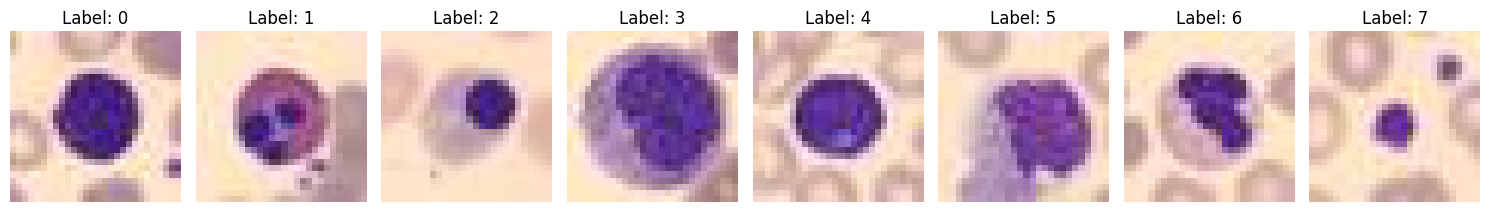

In [5]:
plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(trainset)):
    image, label = trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

In [6]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 200
batch_size = 128

# Architecture
num_classes = 8
num_features = 2352
num_latent = 70

Device: cuda


In [8]:
for images, labels in train_dataloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 28, 28])
Image label dimensions: torch.Size([128, 1])


In [9]:
def to_onehot(labels, num_classes, device):
    labels_onehot=torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot

In [10]:
import torch
import torch.nn.functional as F

class ConditionalVariationalAutoencoder(torch.nn.Module):
    
    def __init__(self, num_features, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()

        self.num_classes = num_classes
        
        # Encoder
        self.enc_conv_1 = torch.nn.Conv2d(in_channels=3 + self.num_classes,
                                          out_channels=16,
                                          kernel_size=(3, 3),
                                          stride=(2, 2),
                                          padding=1)
        
        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(3, 3),
                                          stride=(2, 2),
                                          padding=1)
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(3, 3),
                                          stride=(2, 2),
                                          padding=1)
        
        self.enc_conv_4 = torch.nn.Conv2d(in_channels=64,
                                          out_channels=128,
                                          kernel_size=(3, 3),
                                          stride=(2, 2),
                                          padding=1)
        
        self.enc_conv_5= torch.nn.Conv2d(in_channels=128,
                                          out_channels=256,
                                          kernel_size=(3, 3),
                                          stride=(2, 2),
                                          padding=1)
        
        self.z_mean = torch.nn.Linear(256 * 1 * 1, num_latent)
        self.z_log_var = torch.nn.Linear(256 * 1 * 1, num_latent)

        # Decoder
        self.dec_linear_1 = torch.nn.Linear(num_latent + self.num_classes, 256 * 1 * 1)

        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=256,
                                                     out_channels=128,
                                                     kernel_size=(3, 3),
                                                     stride=(2, 2),
                                                     padding=1, output_padding=1)
        
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=128,
                                                     out_channels=64,
                                                     kernel_size=(3, 3),
                                                     stride=(2, 2),
                                                     padding=1, output_padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=64, 
                                                     out_channels=32,
                                                     kernel_size=(3, 3),
                                                     stride=(2, 2),
                                                     padding=1, output_padding=1)
        
        self.dec_deconv_4 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(3, 3),
                                                     stride=(2, 2),
                                                     padding=2, output_padding=1)
        
        self.dec_deconv_5 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=11,
                                                     kernel_size=(3, 3),
                                                     stride=(2, 2),
                                                     padding=1, output_padding=1)
    
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        z = z_mu + eps * torch.exp(z_log_var / 2.)
        return z
    
    def encoder(self, features, targets):
        onehot_targets = to_onehot(targets, self.num_classes, device)
        onehot_targets = onehot_targets.view(-1, self.num_classes, 1, 1)

        ones = torch.ones(features.size()[0],
                          self.num_classes,
                          features.size()[2],
                          features.size()[3],
                          dtype=features.dtype).to(device)
        
        ones = ones * onehot_targets
        x = torch.cat((features, ones), dim=1)

        x = self.enc_conv_1(x)
        x = F.leaky_relu(x)
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        
        x = self.enc_conv_4(x)
        x = F.leaky_relu(x)

        x = self.enc_conv_5(x)
        x = F.leaky_relu(x)
        
        z_mean = self.z_mean(x.view(-1, 256 * 1 * 1))
        z_log_var = self.z_log_var(x.view(-1, 256 * 1 * 1))
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
        
    def decoder(self, encoded, targets):
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 256, 1, 1)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)

        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        
        x = self.dec_deconv_4(x)
        x = F.leaky_relu(x)
        
        x = self.dec_deconv_5(x)
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        return z_mean, z_log_var, encoded, decoded

torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features,
                                          num_latent,
                                          num_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
start_time = time.time()

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_dataloader):
        
        features = features.to(device)
        targets = targets.to(device)

        z_mean, z_log_var, encoded, decoded = model(features, targets)

        kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        onehot_targets = to_onehot(targets, num_classes, device)
        onehot_targets = onehot_targets.view(-1, num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x_con = torch.cat((features, ones), dim=1)
        
        pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataloader), cost.item()))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


Epoch: 001/200 | Batch 000/094 | Cost: 763963.8750
Epoch: 001/200 | Batch 050/094 | Cost: 480251.1875
Time elapsed: 0.03 min
Epoch: 002/200 | Batch 000/094 | Cost: 461457.6562
Epoch: 002/200 | Batch 050/094 | Cost: 449737.3125
Time elapsed: 0.05 min
Epoch: 003/200 | Batch 000/094 | Cost: 445574.9688
Epoch: 003/200 | Batch 050/094 | Cost: 454293.1875
Time elapsed: 0.07 min
Epoch: 004/200 | Batch 000/094 | Cost: 443718.2188
Epoch: 004/200 | Batch 050/094 | Cost: 389260.5312
Time elapsed: 0.09 min
Epoch: 005/200 | Batch 000/094 | Cost: 317535.6562
Epoch: 005/200 | Batch 050/094 | Cost: 221045.6719
Time elapsed: 0.12 min
Epoch: 006/200 | Batch 000/094 | Cost: 191181.4219
Epoch: 006/200 | Batch 050/094 | Cost: 180102.9219
Time elapsed: 0.14 min
Epoch: 007/200 | Batch 000/094 | Cost: 171742.3281
Epoch: 007/200 | Batch 050/094 | Cost: 170569.5625
Time elapsed: 0.16 min
Epoch: 008/200 | Batch 000/094 | Cost: 167131.8750
Epoch: 008/200 | Batch 050/094 | Cost: 162787.2344
Time elapsed: 0.18 min


Original images shape: torch.Size([10, 3, 28, 28])
Decoded images shape: torch.Size([10, 11, 28, 28])
Original image 0 shape: torch.Size([3, 28, 28])
Decoded image 0 shape: torch.Size([11, 28, 28])
Original image 1 shape: torch.Size([3, 28, 28])
Decoded image 1 shape: torch.Size([11, 28, 28])
Original image 2 shape: torch.Size([3, 28, 28])
Decoded image 2 shape: torch.Size([11, 28, 28])
Original image 3 shape: torch.Size([3, 28, 28])
Decoded image 3 shape: torch.Size([11, 28, 28])
Original image 4 shape: torch.Size([3, 28, 28])
Decoded image 4 shape: torch.Size([11, 28, 28])
Original image 5 shape: torch.Size([3, 28, 28])
Decoded image 5 shape: torch.Size([11, 28, 28])
Original image 6 shape: torch.Size([3, 28, 28])
Decoded image 6 shape: torch.Size([11, 28, 28])
Original image 7 shape: torch.Size([3, 28, 28])
Decoded image 7 shape: torch.Size([11, 28, 28])
Original image 8 shape: torch.Size([3, 28, 28])
Decoded image 8 shape: torch.Size([11, 28, 28])
Original image 9 shape: torch.Size

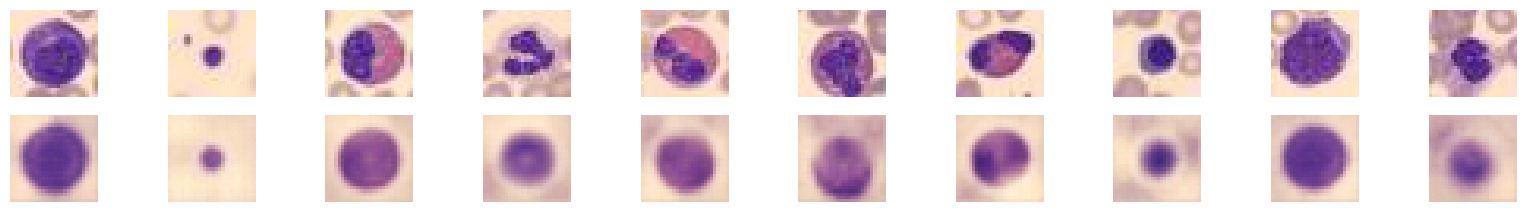

In [14]:
import matplotlib.pyplot as plt

n_images = 10
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))

orig_images = features[:n_images]
decoded_images = decoded[:n_images]

print(f'Original images shape: {orig_images.shape}')
print(f'Decoded images shape: {decoded_images.shape}')

for i in range(n_images):
    ax = axes[0, i]
    img = orig_images[i].detach().to(torch.device('cpu'))
    print(f'Original image {i} shape: {img.shape}') 
    if img.dim() == 3:
        img = img.permute(1, 2, 0)  
    ax.imshow(img)
    ax.axis('off')  

    ax = axes[1, i]
    img = decoded_images[i].detach().to(torch.device('cpu'))
    print(f'Decoded image {i} shape: {img.shape}')  
    if img.dim() == 3:
        img = img[:3].permute(1, 2, 0)  
    ax.imshow(img)
    ax.axis('off') 

plt.show()


Class Label 0


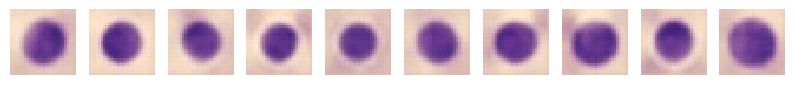

Class Label 1


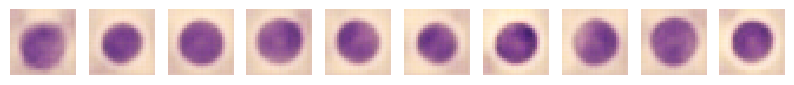

Class Label 2


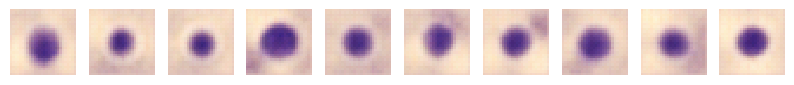

Class Label 3


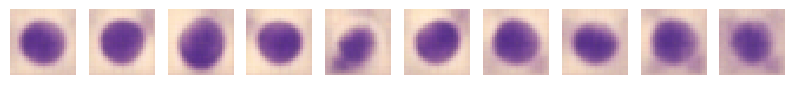

Class Label 4


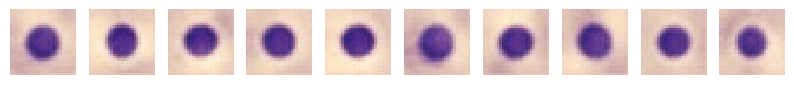

Class Label 5


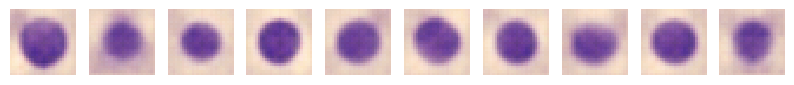

Class Label 6


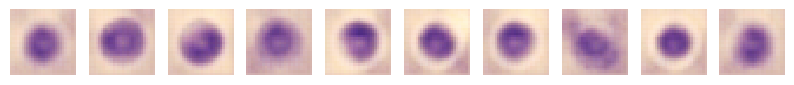

Class Label 7


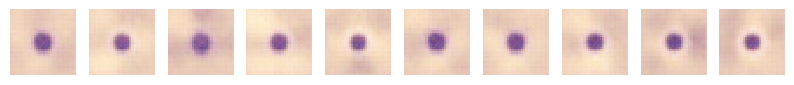

In [15]:
import matplotlib.pyplot as plt
import torch


for i in range(8):   
    
    labels = torch.tensor([i]*10).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features, labels)


    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5))

    print('Class Label %d' % i)

    for ax, img in zip(axes, new_images):
        if img.dim() == 3:
            img = img[:3].permute(1, 2, 0)
        ax.imshow(img.detach().to(torch.device('cpu')), interpolation='nearest')
        ax.axis('off')
        
    plt.show()
